In [1]:
import cvxpy as cp
import numpy as np
import osbdo as ob

from scipy import stats
import time
from scipy import stats

In [2]:
import matplotlib.pyplot as plt

In [3]:
def get_rel_diff(a,b):
    return np.linalg.norm(a-b) / min(np.linalg.norm(a), np.linalg.norm(b)) 

In [4]:
def check_subgrads(agent, ntimes):
    l, u = agent.lwb, agent.upb
    n = agent.dim
    for _ in range(ntimes):
        v = l + np.multiply(np.random.rand(n), u-l)
        point = agent.query(v=v)
        linear = lambda x: point.f + point.q @ (x - point.x)
        for _ in range(10):
            test = l + np.multiply(np.random.rand(n), u-l)
            a = linear(test)
            b = agent.query(v=test).f + 10**(-6)
            assert a <= b, print(a, b, b-a)
    print("passed")

# Walrasian Equilibrium: action directed
$$
\begin{array}{ll}
\mbox{minimize} & \sum_{i=1}^N -U_i(x_i)  \\
\mbox{subject to} & \sum_{i=1}^N x_i = E \\
& x_i  \geq 0, \quad i=1,\ldots, N,
\end{array}
$$
where $U_i(x_i)= \mbox{geomean} \left(A_ix_i+b_i\right)$.

In [5]:
N = 30

params, R = ob.ra_params(num_resources=N, num_agents=N, num_participants=N)

In [6]:
E = R
n = params[0]['dimension']

In [7]:
for j in range(n):
    count = 0
    for i in range(N):
        A = params[i]["A_list"][0]
        if A[0,j] > 0:
            count += 1
    assert count > 0

# Centralized solution

In [8]:
dim = params[0]['dimension']
z = cp.Variable(len(params)*dim)
num_agents = len(params)
constraints = []
f = 0
xi_list = []
start = time.time()
for i in range(num_agents):
    xi = z[(i*dim):((i+1)*dim)]
    X = cp.Variable((len(params[i]['A_list']), dim))
    for j in range(len(params[i]['A_list'])):
        f += -cp.geo_mean(params[i]['A_list'][j] @ X[j].T + params[i]['b_list'][j])
    constraints += [cp.sum(X,axis=0) <= xi, \
                    X>=0, \
                    xi<=params[i]['upper_bound'], 
                    xi>=params[i]['lower_bound']]
    xi_list.append(xi)
constraints += [sum(xi_list)==R]
prob_cvx = cp.Problem(cp.Minimize(f), constraints)
prob_cvx.solve(solver='ECOS')
print(f"elapsed time =  {time.time()-start}")

h_cvx, x_cvx = f.value, z.value
nu_cvx = constraints[-1].dual_value
print(f"{h_cvx = }")

elapsed time =  0.757328987121582
h_cvx = -151.43598262830935


# Walrasian Equilibrium: price directed
$$
\begin{array}{ll}
\mbox{minimize} & \sum_{i=1}^N \underset{x_i\geq 0}{\max} \left(
 U_i(x_i) - \nu_i^Tx_i 
\right ) + \nu_1^T E   \\
\mbox{subject to} & \nu_1=\cdots=\nu_N,
\end{array}
$$
where $U_i(x_i)= \mbox{geomean} \left(A_ix_i+b_i\right)$.

## Describe each $f_i(\nu_i) = \underset{E \geq x_i\geq 0}{\max} \left(
 U_i(x_i) - \nu_i^Tx_i 
\right )= (-U_i)^*(-\nu_i)$.

In [11]:
class GeoMeanConj(ob.Agent):
    """
    fi(nu_i)  = \max_{E\geq x_i\geq 0} ( U_i(x_i) - \nu_i^Tx_i )
    """
    def _construct_params(self):
        self.A = self.params['A']
        self.b = self.params['b']
        self.E = self.params['E']
        self.nu_max = self.params['nu_max']

    def query(self, *, v, solver='ECOS'):
        x = cp.Variable((self.dim), nonneg=True)
        f = cp.geo_mean(self.A @ x + self.b) - v @ x
        prob = cp.Problem(cp.Maximize(f), [x <= self.E])
        prob.solve(solver=cp.MOSEK)
        f = f.value
        q = -x.value
        return ob.Point(x=v, q=q, f=f)
    
    def get_init_minorant(self):
        lwb = stats.mstats.gmean(self.b, axis=None) - self.E @ self.nu_max
        return cp.Constant(lwb)
    
def get_total_obj(agents, xs):
    obj = 0
    for agent in agents:
        obj += stats.mstats.gmean(agent.A @ xs[i] + agent.b, axis=None)
    return -obj

In [13]:
agents = [0]*N
nu_params = []
for i  in  range(N): 
    nu_params += [{ 'dimension':n, 
                    'lower_bound':0, 
                    'upper_bound':None,
                    'nu_max':None,
                    'E':E,
                    'A':params[i]["A_list"][0],
                    'b':params[i]["b_list"][0]}]
    
    agents[i] = GeoMeanConj(nu_params[i])

# Dual Subgradient Method with Averaging (DSMA) 

In [15]:
k = 0
p = np.zeros(n)
solver='ECOS'
xis = np.zeros((N, n))
gamma_k = 0 
rgap = np.inf
max_iters = 800
d_vals = []
p_vals = [np.inf]

In [19]:
start = time.time()
while  k <= max_iters: 
    dual_val = E @ p
    
    for i in range(N):
        point = agents[i].query(v=p, solver=solver)
        xi = -point.q
        dual_val += point.f
        xis[i] = (k/(k+1)) * xis[i] + 1./(k+1) * xi
        
    gamma_k = (k/(k+1)) * gamma_k + 1./(k+1) * (1./np.sqrt(k+1))
    access_demand = np.max(np.stack([sum(xis) - E, np.zeros(n)], axis=1), axis=1)
    p_plus = (1./gamma_k) * access_demand
    
    p_val = np.inf
    if (E - sum(xis)>= -10**(-8)).all():
        p_val = get_total_obj(agents, xis)
        
    p_vals += [min(p_val, p_vals[-1])]
    
    p = ((k+1)/(k+2)) * p + 1./(k+2) * p_plus
        
    print(f"{k = }, opt_gap={get_rel_diff(h_cvx, -dual_val)}, g(p) = {-dual_val}, U={p_vals[-1]}")
    k += 1
    d_vals += [dual_val]
print(f"elapsed time =  {time.time()-start}")

k = 0, opt_gap=148.42166104405715, g(p) = -22627.816066160965, U=-41.14637606606268
k = 1, opt_gap=73.8470178410517, g(p) = -11334.531693558263, U=-41.14637607479255
k = 2, opt_gap=48.989186092703136, g(p) = -7570.161516737915, U=-41.14637607836947
k = 3, opt_gap=36.5605274968583, g(p) = -5688.015389524368, U=-41.146376313614525
k = 4, opt_gap=29.10350406576766, g(p) = -4558.7537187548305, U=-41.14637637330002
k = 5, opt_gap=24.132281271801148, g(p) = -3805.931710086263, U=-41.14637637330002
k = 6, opt_gap=20.581506604731135, g(p) = -3268.216659286808, U=-41.14637678271328
k = 7, opt_gap=17.91850654156419, g(p) = -2864.9426279818717, U=-41.14637678271328
k = 8, opt_gap=15.84735310164787, g(p) = -2551.2954716341405, U=-41.14637702836499
k = 9, opt_gap=14.190542935027143, g(p) = -2300.3947960233577, U=-41.14637702836499
k = 10, opt_gap=12.835127413115654, g(p) = -2095.1361145930287, U=-41.14637702836499
k = 11, opt_gap=11.705782320427643, g(p) = -1924.1126307553604, U=-41.14637702836499


k = 97, opt_gap=0.9952093290735272, g(p) = -302.1464852974194, U=-41.146379879048695
k = 98, opt_gap=0.9843288803883443, g(p) = -300.49879385934184, U=-41.146379879048695
k = 99, opt_gap=0.9736770129350188, g(p) = -298.885717844721, U=-41.146379879048695
k = 100, opt_gap=0.9624364175585882, g(p) = -297.183487238564, U=-41.146379879048695
k = 101, opt_gap=0.948996538110946, g(p) = -295.14820588800427, U=-41.146379879048695
k = 102, opt_gap=0.934808142135434, g(p) = -292.99957220153306, U=-41.146379879048695
k = 103, opt_gap=0.9224996442236669, g(p) = -291.13562272558613, U=-41.146379879048695
k = 104, opt_gap=0.9114400936156112, g(p) = -289.4608088118277, U=-41.146379879048695
k = 105, opt_gap=0.9009094948669002, g(p) = -287.8660972426522, U=-41.146379879048695
k = 106, opt_gap=0.8910104527444741, g(p) = -286.3670260717636, U=-41.146379879048695
k = 107, opt_gap=0.878919744119108, g(p) = -284.5360577304087, U=-41.146379879048695
k = 108, opt_gap=0.865637184446374, g(p) = -282.5246002545

k = 192, opt_gap=0.43992281609243655, g(p) = -218.0561265638805, U=-41.146379879048695
k = 193, opt_gap=0.43879661481485954, g(p) = -217.88557916677337, U=-41.146379879048695
k = 194, opt_gap=0.4375159303694113, g(p) = -217.69163745934011, U=-41.146379879048695
k = 195, opt_gap=0.43615026261952383, g(p) = -217.48482622169212, U=-41.146379879048695
k = 196, opt_gap=0.43460531555881476, g(p) = -217.25086564544492, U=-41.146379879048695
k = 197, opt_gap=0.43287637959403785, g(p) = -216.9890425287175, U=-41.146379879048695
k = 198, opt_gap=0.4309773478116652, g(p) = -216.70146078471151, U=-41.146379879048695
k = 199, opt_gap=0.4288921173414777, g(p) = -216.38568185945218, U=-41.146379879048695
k = 200, opt_gap=0.42664135731976927, g(p) = -216.04483580390425, U=-41.146379879048695
k = 201, opt_gap=0.42426466899227755, g(p) = -215.6849196716293, U=-41.146379879048695
k = 202, opt_gap=0.42183995482683767, g(p) = -215.31773069939314, U=-41.146379879048695
k = 203, opt_gap=0.4193826577135083, g

k = 287, opt_gap=0.2598518978716227, g(p) = -190.78691012032962, U=-41.146379879048695
k = 288, opt_gap=0.25669793531132656, g(p) = -190.30928670083827, U=-41.146379879048695
k = 289, opt_gap=0.2533944296159478, g(p) = -189.80901706974038, U=-41.146379879048695
k = 290, opt_gap=0.2501371048433199, g(p) = -189.31574089205793, U=-41.146379879048695
k = 291, opt_gap=0.24747150515597457, g(p) = -188.91207318411108, U=-41.146379879048695
k = 292, opt_gap=0.2453666690904236, g(p) = -188.59332526625286, U=-41.146379879048695
k = 293, opt_gap=0.24356869567419523, g(p) = -188.32104739522674, U=-41.146379879048695
k = 294, opt_gap=0.24187554116682888, g(p) = -188.06464287866217, U=-41.146379879048695
k = 295, opt_gap=0.24024952501354604, g(p) = -187.81840552472028, U=-41.146379879048695
k = 296, opt_gap=0.2387443879002498, g(p) = -187.59047360697792, U=-41.146379879048695
k = 297, opt_gap=0.2374746920166892, g(p) = -187.3981959632118, U=-41.146379879048695
k = 298, opt_gap=0.2362844212236088, g(

k = 381, opt_gap=0.13599402668711513, g(p) = -172.03037169125315, U=-41.146379879048695
k = 382, opt_gap=0.13654269160534713, g(p) = -172.1134593022793, U=-41.146379879048695
k = 383, opt_gap=0.13709995757252855, g(p) = -172.19784942160473, U=-41.146379879048695
k = 384, opt_gap=0.137620967538861, g(p) = -172.27674907781542, U=-41.146379879048695
k = 385, opt_gap=0.13789620476736536, g(p) = -172.31842989796988, U=-41.146379879048695
k = 386, opt_gap=0.13791717879387422, g(p) = -172.32160612028392, U=-41.146379879048695
k = 387, opt_gap=0.13769651199665167, g(p) = -172.28818922701308, U=-41.146379879048695
k = 388, opt_gap=0.13730009739871857, g(p) = -172.22815779284687, U=-41.146379879048695
k = 389, opt_gap=0.13680244950649312, g(p) = -172.1527959952848, U=-41.146379879048695
k = 390, opt_gap=0.13623345258389555, g(p) = -172.06662938719876, U=-41.146379879048695
k = 391, opt_gap=0.13559606205039781, g(p) = -171.97010552544054, U=-41.146379879048695
k = 392, opt_gap=0.13490703061456355

k = 475, opt_gap=0.07720320568493794, g(p) = -163.1273259432634, U=-41.146379879048695
k = 476, opt_gap=0.07680413599779068, g(p) = -163.06689243305308, U=-41.146379879048695
k = 477, opt_gap=0.07640788395841912, g(p) = -163.00688561610238, U=-41.146379879048695
k = 478, opt_gap=0.07601427284921985, g(p) = -162.94727873100737, U=-41.146379879048695
k = 479, opt_gap=0.07562436072803197, g(p) = -162.8882320057966, U=-41.146379879048695
k = 480, opt_gap=0.07524087228652572, g(p) = -162.8301580568305, U=-41.146379879048695
k = 481, opt_gap=0.07486736178718881, g(p) = -162.77359512734142, U=-41.146379879048695
k = 482, opt_gap=0.07449885499102071, g(p) = -162.7177899385585, U=-41.146379879048695
k = 483, opt_gap=0.07413105990485568, g(p) = -162.66209252827923, U=-41.146379879048695
k = 484, opt_gap=0.07377192756418757, g(p) = -162.60770696937655, U=-41.146379879048695
k = 485, opt_gap=0.0734230393293626, g(p) = -162.55487273670838, U=-41.146379879048695
k = 486, opt_gap=0.07307763726521316,

k = 569, opt_gap=0.04904356326982896, g(p) = -158.86294282366956, U=-41.146379879048695
k = 570, opt_gap=0.04935373855491541, g(p) = -158.90991452275364, U=-41.146379879048695
k = 571, opt_gap=0.04971114790034891, g(p) = -158.9640391581799, U=-41.146379879048695
k = 572, opt_gap=0.05009648968082706, g(p) = -159.02239376935435, U=-41.146379879048695
k = 573, opt_gap=0.050497392047561436, g(p) = -159.0831048131988, U=-41.146379879048695
k = 574, opt_gap=0.0508863387471436, g(p) = -159.14200533884005, U=-41.146379879048695
k = 575, opt_gap=0.0512373222722033, g(p) = -159.1951568738438, U=-41.146379879048695
k = 576, opt_gap=0.05156614999837677, g(p) = -159.24495322367233, U=-41.146379879048695
k = 577, opt_gap=0.05188047538488626, g(p) = -159.2925533974434, U=-41.146379879048695
k = 578, opt_gap=0.05214887517018855, g(p) = -159.3331987826679, U=-41.146379879048695
k = 579, opt_gap=0.05236916350871039, g(p) = -159.3665583636735, U=-41.146379879048695
k = 580, opt_gap=0.052538474148382516, 

k = 663, opt_gap=0.016649788600245723, g(p) = -153.95735972554118, U=-41.146379879048695
k = 664, opt_gap=0.016435240406812286, g(p) = -153.92486940904746, U=-41.146379879048695
k = 665, opt_gap=0.016205944022515635, g(p) = -153.89014568577838, U=-41.146379879048695
k = 666, opt_gap=0.015988851409814892, g(p) = -153.8572700526527, U=-41.146379879048695
k = 667, opt_gap=0.01579556763319834, g(p) = -153.82799993401466, U=-41.146379879048695
k = 668, opt_gap=0.015617840505003111, g(p) = -153.8010856517167, U=-41.146379879048695
k = 669, opt_gap=0.015453067812167534, g(p) = -153.77613313706684, U=-41.146379879048695
k = 670, opt_gap=0.015290531006049836, g(p) = -153.75151921611914, U=-41.146379879048695
k = 671, opt_gap=0.01512773468571072, g(p) = -153.7268659953803, U=-41.146379879048695
k = 672, opt_gap=0.014964015715981473, g(p) = -153.70207305232447, U=-41.146379879048695
k = 673, opt_gap=0.014800938944457507, g(p) = -153.67737736118488, U=-41.146379879048695
k = 674, opt_gap=0.0146436

k = 756, opt_gap=0.013329237935510592, g(p) = -153.45450887275993, U=-41.146379879048695
k = 757, opt_gap=0.013879684690112705, g(p) = -153.53786631792767, U=-41.146379879048695
k = 758, opt_gap=0.014431703011593038, g(p) = -153.62146175486987, U=-41.146379879048695
k = 759, opt_gap=0.014982171225415158, g(p) = -153.70482244973567, U=-41.146379879048695
k = 760, opt_gap=0.015530155040990352, g(p) = -153.7878069173117, U=-41.146379879048695
k = 761, opt_gap=0.016073969909127406, g(p) = -153.87016005623593, U=-41.146379879048695
k = 762, opt_gap=0.01660947506352641, g(p) = -153.95125480549487, U=-41.146379879048695
k = 763, opt_gap=0.017136209417818803, g(p) = -154.03102134002123, U=-41.146379879048695
k = 764, opt_gap=0.01765461974486712, g(p) = -154.10952731730245, U=-41.146379879048695
k = 765, opt_gap=0.01816565864887423, g(p) = -154.18691699589206, U=-41.146379879048695
k = 766, opt_gap=0.018667261342291727, g(p) = -154.26287769265875, U=-41.146379879048695
k = 767, opt_gap=0.019158

In [21]:
h_cvx, get_rel_diff(-d_vals[-1], h_cvx)

(-151.43598262830935, 0.023008363976539502)

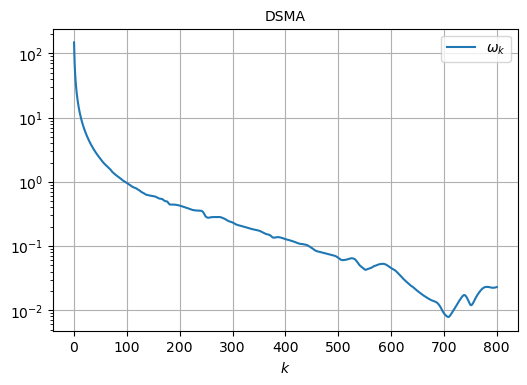

In [36]:
opt_gap = np.abs(h_cvx*np.ones(len(d_vals))+np.array(d_vals)) / \
                        np.minimum(np.abs(h_cvx*np.ones(len(d_vals))), np.abs(np.array(d_vals)))
fig, ax1 = plt.subplots()
fig.set_dpi(100)
ax1.grid()
plt.title("DSMA", fontsize=10)
ax1.plot(opt_gap, label=r'$\omega_k$')
ax1.set_xlabel(r'$k$', fontsize=10)
ax1.set_yscale('log')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels , loc=0, fontsize=10)
plt.show() 